# SST: Analysis for Item Test

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

## Setup paths

In [50]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')

In [51]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)

subj_info

,subid,group,voltage,remove
0,1,pilot,0,NaN
1,2,pilot,0,NaN
2,3,pilot,0,NaN
3,4,pilot,0,NaN


## Load in data

In [69]:
dt = pd.DataFrame() 
test = True
questionnaires_post  = False

for subid in subj_info.subid:
    print subid

    if test:
        # add test file
        test_file = op.join(dirs['datadir'], subid, subid + '_behav_itemTest_coded.csv')
        d2 = pd.read_csv(test_file)
        d2['subid'] = subid
        dt = dt.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)

1
2
3
4


In [70]:
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid
0,7,1,3,39.8986,19.2681,Town1,env1.jpg,1,zebra,6.7555,animal,1,1
1,8,1,3,39.8986,19.2681,Town1,env1.jpg,2,george clooney,5.7986,face,1,1
2,9,1,3,39.8986,19.2681,Town1,env1.jpg,3,Lettuce,6.7118,object,1,1
3,52,2,6,89.7360,8.8618,Town1,env1.jpg,1,zebra,3.0541,animal,1,1
4,53,2,6,89.7360,8.8618,Town1,env1.jpg,2,george clooney,3.5342,face,1,1


## Analysis

### Accuracy across runs, by type of item

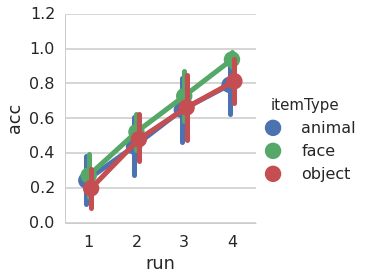

In [71]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.1,
               units='subid', ci=68, data=data)

#### Mean accuracy and standard error for final (4th) run

In [100]:
data = dt[dt.run == 4].groupby(['itemType']).mean().reset_index()[['itemType', 'acc']]
data['st.err'] = dt[dt.run == 4].groupby(['itemType']).std().reset_index()[['acc']]/subj_info.subid.size
data

,itemType,acc,st.err
0,animal,0.791667,0.102604
1,face,0.937500,0.061156
2,object,0.812500,0.098611


#### Broken down by subject

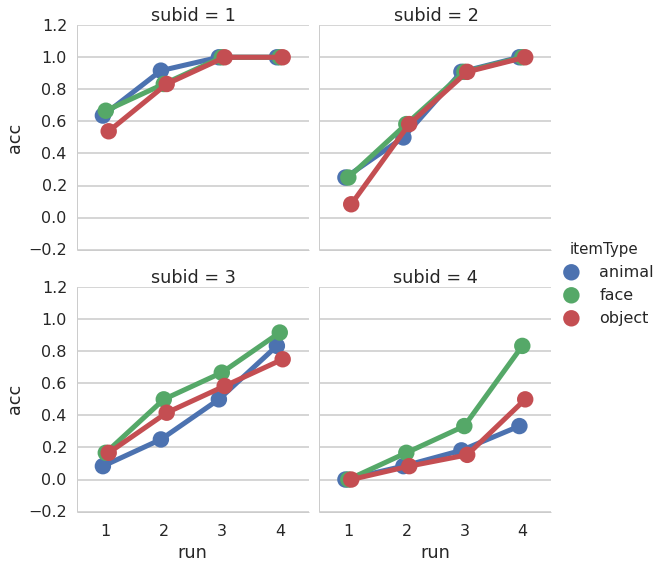

In [72]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.1,
               col='subid', col_wrap=2, data=data)

### Final accuracy for item types

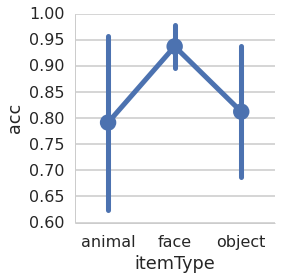

In [76]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='itemType', y='acc',
               dodge=.1,
               units='subid', ci=68, data=data)

#### Statistical difference between acc for different item types?

In [111]:
data = dt[dt.run == 4].groupby(['itemType', 'subid', 'town']).mean().reset_index()[['subid', 'itemType', 'acc', 'town']]
%R -i data

In [118]:
%%R

res1 = lmer(acc ~ itemType + (1 | subid) + (1 | town), data=data)
res2 = lmer(acc ~ itemType + (1 | subid), data=data)
print(anova(res1, res2, refit=FALSE))

print(summary(res2))

Data: data
Models:
..1: acc ~ itemType + (1 | subid)
object: acc ~ itemType + (1 | subid) + (1 | town)
       Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
..1     5 100.20 115.05 -45.098   90.197                         
object  6 100.83 118.65 -44.416   88.833 1.3642      1     0.2428
Linear mixed model fit by REML ['merModLmerTest']
Formula: acc ~ itemType + (1 | subid)
   Data: data

REML criterion at convergence: 90.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9788 -0.2610  0.2090  0.6462  1.5539 

Random effects:
 Groups   Name        Variance Std.Dev.
 subid    (Intercept) 0.04131  0.2032  
 Residual             0.09632  0.3103  
Number of obs: 144, groups:  subid, 4

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)   
(Intercept)      0.79167    0.11105   3.77000   7.129  0.00255 **
itemTypeface     0.14583    0.06335 137.96000   2.302  0.02283 * 
itemTypeobject   0.02083    0.06335 137.96000   0.329  0.74276   
---

### Accuracy across environments

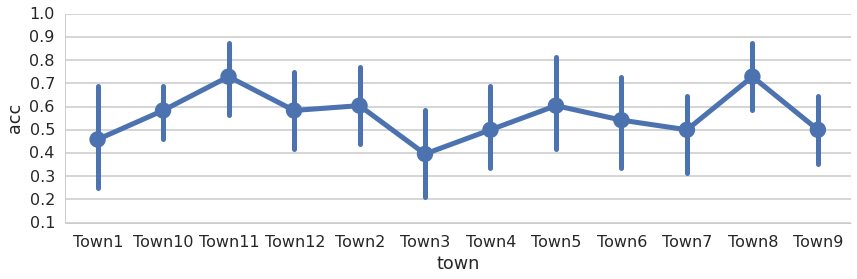

In [73]:
data = dt.groupby(['subid', 'run', 'town']).mean().reset_index()
sns.factorplot(x='town', y='acc', 
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

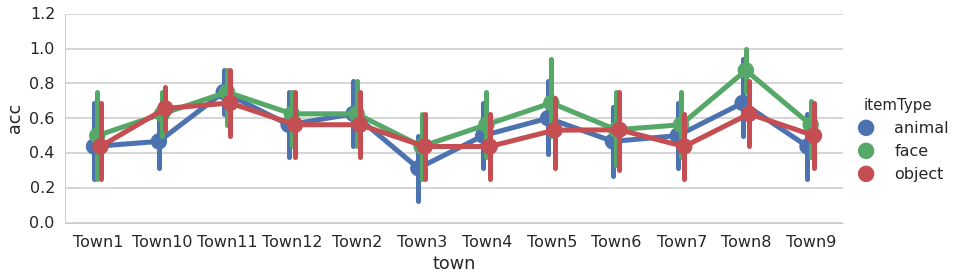

In [77]:
data = dt.groupby(['subid', 'run', 'town', 'itemType']).mean().reset_index()
sns.factorplot(x='town', y='acc', hue='itemType',
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

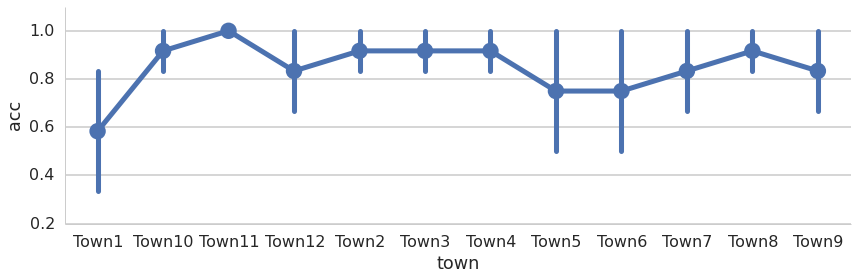

In [121]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town']).mean().reset_index()
sns.factorplot(x='town', y='acc', 
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

### Order of recalling items

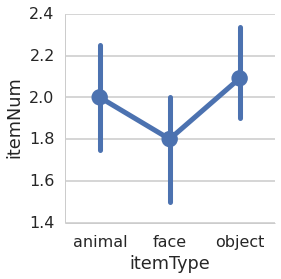

In [122]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'itemNum', 'itemType']).mean().reset_index()
sns.factorplot(x='itemType', y='itemNum', 
               dodge=.1,
               units='subid', ci=68, data=data)

## RTs

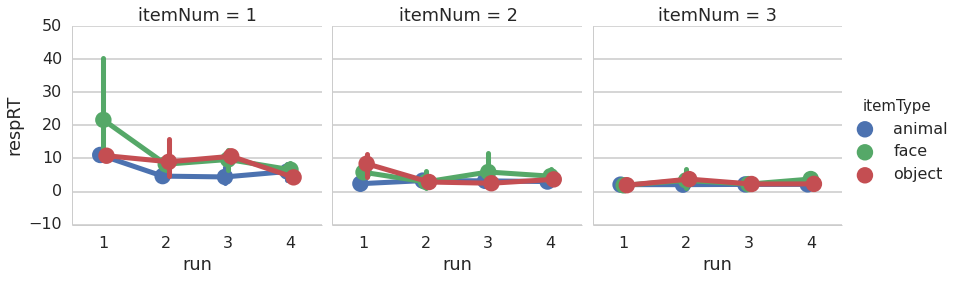

In [84]:
data = dt.groupby(['subid', 'run', 'itemType', 'itemNum']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType',
               col='itemNum',
               dodge=.1,
               data=data)